This notebook is entirely based on the Pytorch tutorial available on their website here: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html. 

I have included extra notes and comments for further explanation for noobs like myself. I have also made changes where the code in the tutorial didn't run

## Neural Style Transfer

### Introduction
This tutorial explains how to implement the Neural-Style algorithm developed by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge. Neural-Style, or Neural-Transfer, allows you to take an image and reproduce it with a new artistic style. The algorithm takes three images, an input image, a content-image, and a style-image, and changes the input to resemble the content of the content-image and the artistic style of the style-image.

## Note for Noobs
- The pretrained network we use is just a feature extractor and is never updated during the training process
- The feature maps produced after every convolution at each level are also not changed at any point
- The target image is the only entity that is changed and is compared to the static feature maps in order to quantify the 'distance' between the target image and the content and style images (also described as the content loss and style loss)
- The target image is passed to an optimiser which calculates the total loss gradients (distance) during back propagation
- The gradients are used to update the pixels of the target image

### Underlying Principle
The principle is simple: we define two distances, one for the content (
D 
C
 ) and one for the style (
D 
S
 ). 
 
 <b>In this context, distance can be described as being quantified using feature representations extracted from different layers of a convolutional neural network</b>

D 
C
  measures how different the content is between two images while 
D 
S
  measures how different the style is between two images. Then, we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image. Now we can import the necessary packages and begin the neural transfer.

In [2]:
import torch                     # Main PyTorch library, provides tensor object and operations
import torch.nn as nn            # Provides building blocks for neural networks (like layers, activation functions)
import torch.nn.functional as F  # Functional interface, provides functions like activation functions and convolution operations
import torch.optim as optim      # Optimization algorithms module, contains optimizers like SGD, Adam

from PIL import Image            # Python Imaging Library, used for interactions with many image formats
import matplotlib.pyplot as plt  # Matplotlib's pyplot, a plotting library for creating graphs and visualizations

import torchvision.transforms as transforms  # Provides common image transformations for preprocessing
import torchvision.models as models          # Contains pre-defined and pre-trained models like VGG, ResNet

import copy                      # Used to create deep copies of objects (like copying images or model parameters)


### Loading the Images
Now we will import the style and content images. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. The images also need to be resized to have the same dimensions. An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1. <b>If you try to feed the networks with 0 to 255 tensor images, then the activated feature maps will be unable to sense the intended content and style.</b> However, pretrained networks from the Caffe library are trained with 0 to 255 tensor images.

<i>When putting input through a neural network, one of the dimensions given in the tensor shape is for batch size, which specifies how many different inputs are being passed to the network in a single iteration. As we are dealing with a single image for every pass through the network, the batch size dimension is technically non-existent, but the loader expects a dimension. "unsqueeze(0)" adds an artificial dimension to the tensor to satisfy the compatibility of the tensor's shape.</i>

In [3]:
# function to load and transform the image to the uniform shape expected by the network

def image_loader(image_name, target_size=(128, 128)):
    loader = transforms.Compose([        # combine several transforms in a list
        transforms.Resize(target_size),  # Resize the image to the target size
        transforms.ToTensor()])          # Transform it into a torch tensor

    image = Image.open(image_name)       # open the image here, convert it below
    
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0) # add a zeroth dimension for batch_size to conform to pytorch tensor shape conventions
    return image.to("cpu", torch.float)

In [4]:
# load the two images for style and content
style_img = image_loader("./images/picasso.jpg")
content_img = image_loader("./images/dancing.jpg")

# assert the images are equal size
assert style_img.size() == content_img.size(),\
"we need to import style and content images of the same size"

Now, let’s create a function that displays an image by reconverting a copy of it to PIL format and displaying the copy using plt.imshow. We will try displaying the content and style images to ensure they were imported correctly.

In [5]:
unloader = transforms.ToPILImage()  # reconvert tensor back into PIL image

plt.ion() # interactive mode on - plot window updated for every plotting command executed

In [6]:
# function that takes a tensor, converts it and displays it as an image
def imshow(tensor, title=None):
    image = tensor.cpu().clone() # clone the input tensor to not change original
    image = image.squeeze(0)     # remove dimension at position 0 (batch_size) of the tensor dims: (N, Colour, Height, Width)
    image = unloader(image)      # convert to PIL image using function above
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that the display window is updated as the code runs

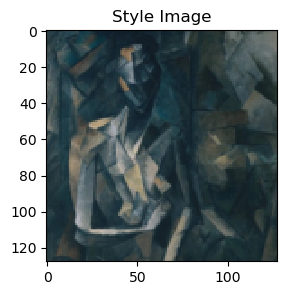

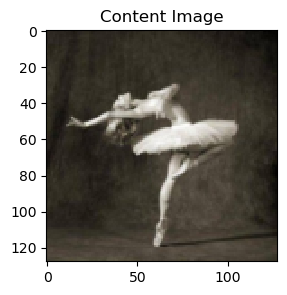

In [24]:
plt.figure(figsize=(3,3))
imshow(style_img, title='Style Image')

plt.figure(figsize=(3,3))
imshow(content_img, title='Content Image')

## Note for Noobs:

- A feature map is the output of a layer in the network after its filter has processed the image.

- Distinctive features of an image lead to correlations across the output of different layers (feature maps), which are used to maintain the essence of the image.

- The style is captured specifically by comparing Gram matrices (texture info) of feature maps

### Difference between identifying the content of the content image and the style of the style image:
- The raw feature maps of standard convolutions pick out objects and features just fine.
- Gram matrices abstract away the objects and features while retaining information on how the objects and features interact and are distributed (artistic style)

### An intuitive explanation of Gram matrices:
Imagine the feature maps as brushes of different sizes and shapes that the network uses to paint an image. The Gram matrix then captures how frequently each pair of brushes is used together. If two brushes (feature maps) tend to activate together, their corresponding value in the Gram matrix will be high. By aligning the Gram matrix of an input image to that of a style image, you're essentially making the input image use its brushes in the same way the style image does, thereby transferring the style.

In summary, the Gram matrix is a crucial component in the neural style transfer algorithm, allowing for the quantification and transfer of artistic styles from one image to another.


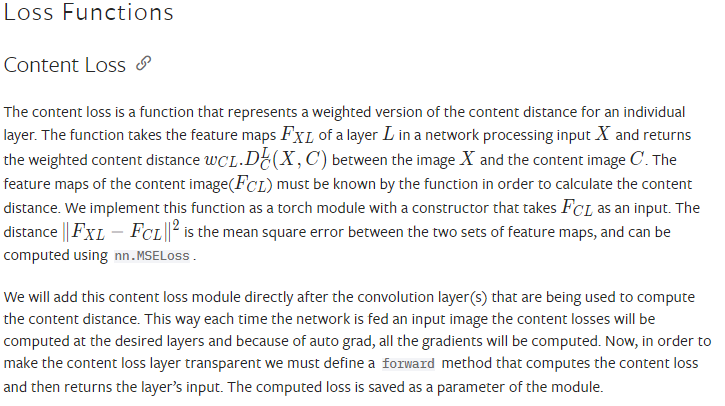

In [25]:
""" This class attempts to retain the content of the content image by
minimising the 'distance' between the target image and the content image """ 

class ContentLoss(nn.Module): # nn.Module is the base class for all nerual network modules in Pytorch
    
    # constructor
    def __init__(self, target):
        # 'target' is the feature map of the content image at a specified layer in the network
        
        # call the constructor of the base class (nn.Module)
        super(ContentLoss, self).__init__()
        
        self.target = target.detach() # the feature maps will not be affected through back propagation
        
        """ In neural style transfer, the target content and style feature maps
        (derived from the content and style images, respectively) are static targets.
        The network's weights remain static while the input/output (target image) is changed,
        rather than the input changing the weights through back propagation.
        It's used to store the static content target feature map that the input will be compared against."""
        
    # forward method automatically called when forward computation is run on an 'nn.Module'
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

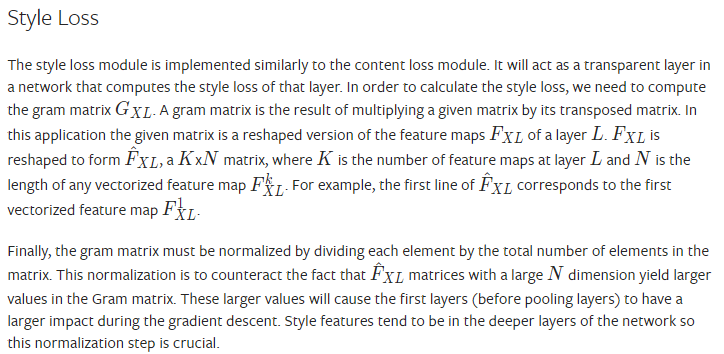

In [87]:
def gram_matrix(input):
    a,b,c,d = input.size() # a=batch size(=1)
    # b=number offeature maps
    # (c,d)=dimensions of a f.map (N=c*d)
    
    features = input.view(a*b, c*d) # resize F_XL into \hat F_XL
    
    G = torch.mm(features, features.t()) # compute the gram product
    
    # we normalize the values of the gram matrix
    # by dividing by the nmber of element in each feature maps
    
    return G.div(a*b*c*d)

Now the style loss module looks almost exactly like the content loss module. The style distance is also computed using the mean square error between 
G 
XL
​
  and 
G 
SL
​
 .

In [88]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### Importing the Model
Now we need to import a pretrained neural network. We will use a 19 layer VGG network like the one used in the paper.

PyTorch’s implementation of VGG is a module divided into two child Sequential modules: features (containing convolution and pooling layers), and classifier (containing fully connected layers). We will use the features module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().

In [89]:
cnn = models.vgg19(pretrained = True)

In [90]:
cnn.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [91]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

A Sequential module contains an ordered list of child modules. For instance, vgg19.features contains a sequence (Conv2d, ReLU, MaxPool2d, Conv2d, ReLU…) aligned in the right order of depth. We need to add our content loss and style loss layers immediately after the convolution layer they are detecting. To do this we must create a new Sequential module that has content loss and style loss modules correctly inserted.

## Helper function to handle sequential layers

In [92]:
def process_layer(layer, model, i, content_img, style_img, content_layers, style_layers, content_losses, style_losses):
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = f'conv_{i}'
    elif isinstance(layer, nn.ReLU):
        name = f'relu_{i}'
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = f'pool_{i}'
    elif isinstance(layer, nn.BatchNorm2d):
        name = f'bn_{i}'
    elif isinstance(layer, nn.Sequential):
        # For Sequential layer, process its children
        for child in layer.children():
            i=process_layer(child, model, i, content_img, style_img, content_layers, style_layers, content_losses, style_losses)
        return i
    elif isinstance(layer, nn.AdaptiveAvgPool2d):
        name = 'adaptive_pool_{}'.format(i)  # Name the layer
        model.add_module(name, layer)  
    elif isinstance(layer, nn.Linear):
        name = 'fc_{}'.format(i)  # Naming convention for fully connected layers
        model.add_module(name, layer)
    elif isinstance(layer, nn.Dropout):
        name = 'dropout_{}'.format(i)
        model.add_module(name, layer)
    else:
        raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

    model.add_module(name, layer)

    if name in content_layers:
        target = model(content_img).detach()
        content_loss = ContentLoss(target)
        model.add_module(f"content_loss_{i}", content_loss)
        content_losses.append(content_loss)

    if name in style_layers:
        target_feature = model(style_img).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module(f"style_loss_{i}", style_loss)
        style_losses.append(style_loss)

    return i


In [93]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        i = process_layer(layer, model, i, content_img, style_img, content_layers, style_layers, content_losses, style_losses)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Next, we select the input image. You can use a copy of the content image or white noise.

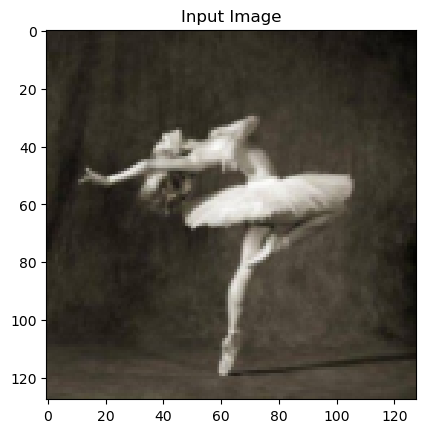

In [94]:
input_img = content_img.clone()
# if you want to use white noise by using the following code:
#
# ::
#
#    input_img = torch.randn(content_img.data.size())

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

### Gradient Descent
As Leon Gatys, the author of the algorithm, suggested here, we will use L-BFGS algorithm to run our gradient descent. Unlike training a network, we want to train the input image in order to minimize the content/style losses. We will create a PyTorch L-BFGS optimizer optim.LBFGS and pass our image to it as the tensor to optimize.

In [95]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

Finally, we must define a function that performs the neural transfer. For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamically compute their gradients. The optimizer requires a “closure” function, which reevaluates the module and returns the loss.

We still have one final constraint to address. The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. We can address this by correcting the input values to be between 0 to 1 each time the network is run.

In [96]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Finally, we can run the algorithm.

Building the style transfer model..
Optimizing..


C:\Users\Tunist\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == "":
C:\Users\Tunist\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss : 83.190193 Content Loss: 17.794182

run [100]:
Style Loss : 25.631123 Content Loss: 16.278793

run [150]:
Style Loss : 10.709321 Content Loss: 14.414684

run [200]:
Style Loss : 5.577436 Content Loss: 12.654232

run [250]:
Style Loss : 3.502997 Content Loss: 11.063227

run [300]:
Style Loss : 2.709741 Content Loss: 9.923200



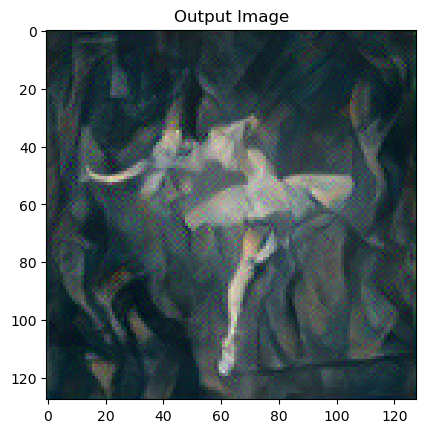

In [97]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()